# Phonebook Diver

This cookbook is create to be used in parallel with The Phone Book Diver project. It can be used to analyze the data.

To get started you must

1. load the libraries
2. extinguish a database connection
3. initialize the helper functions

### Basic Setup and helper functions

Load libraries and connect to database

In [1]:
import requests
import pymongo
from pymongo import MongoClient, UpdateOne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings

In [2]:
# Extinguish connection
MONGO_URI = 'mongodb://localhost:27017'

try:
  client = MongoClient(MONGO_URI)
  db = client.phonebookdiver
except pymongo.errors.ConnectionFailure as err:
  print(err)
else:
  print(f'CONNECTED to {MONGO_URI} {db.name}')

CONNECTED to mongodb://localhost:27017 phonebookdiver


#### Helper functions

The following functions need to be initialized first to be used later

In [3]:
def elapsed_time(start, end):
    time_since = end - start
    return str(time_since) + ' seconds'

In [4]:
def export_results(results, collection, values):
    path = r'./' + values[0] + '/'+ collection
    for v in values:
        path += '_' + v
    path += '.csv'
    results.to_csv(path)

In [5]:
def get_record_by_id(collection, id):
    return pd.DataFrame(db[collection].find({'_id': id}))

In [6]:
def trace_phonenr(area_code, phone_nr):
    records = []
    for  c in collections:
        record = db[c].find_one({'area_code': area_code, 'phonenumber': phone_nr})
        if record is not None:
            record['collection'] = c
            records.append(record)

    return pd.DataFrame(records)

In [7]:
 def create_collection(collection_name, dataframe, reset_index):
    start = time.time()
    if collection_name in db.list_collection_names(): 
        return f'Collection {collection_name} already exists.'
    dataframe.reset_index(inplace=reset_index)
    data_dict = dataframe.to_dict("records")
    db[collection_name].insert_many(data_dict)
    t = elapsed_time(start, time.time())
    return f'Collection {collection_name} successfully inserted. {t}'

In [8]:
# create new INDEX in all collections
def create_index_on_fields(field_names):
    start = time.time()
    for field_name in field_names:
        for c in collections:
            db.get_collection(c).create_index(field_name)
        print(f'{field_name} {elapsed_time(start, time.time())}')
    return elapsed_time(start, time.time())
    # 5152.3292899131775 seconds [area_code] (85 minutes)
    # 4967.730529785156 seconds , #2 '4937.383540868759 seconds' [zip]
    # 5070.640741109848 seconds [city]

In [9]:
def create_index_on_field(field_name):
    start = time.time()
    for c in collections:
        db.get_collection(c).create_index(field_name)
    return elapsed_time(start, time.time())

# create_index_on_field('city')

In [10]:
fields = ['zip', 'city']
for field in fields:
    # create_index_on_field(field)
    db.get_collection('geodata').create_index(field)

#### Get list of telephone book collections

In [10]:
collections = []
ignore = ['geodata', 'counties', 'states', 'zips_cities_counties_states']
for key in dict.fromkeys(db.list_collection_names(), 'name'):
    collections.append(key)
collections.sort()
# remove collections that are not a phone book
for i in ignore:
    if i in collections:
        collections.remove(i)
collections

['1992_Q2',
 '1995_Q0',
 '1996_Q0',
 '1996_Q1',
 '1997_Q1',
 '1997_Q3',
 '1998_Q1',
 '1998_Q3',
 '1999_Q1',
 '1999_Q3',
 '2000_Q1',
 '2000_Q3',
 '2001_Q1',
 '2001_Q2',
 '2001_Q3',
 '2001_Q4',
 '2002_Q1',
 '2002_Q3',
 '2003_Q1',
 '2003_Q3',
 '2004_Q1',
 '2004_Q3',
 '2005_Q1',
 '2005_Q3',
 '2006_Q1',
 '2006_Q3',
 '2007_Q1',
 '2007_Q3',
 '2008_Q1',
 '2008_Q3',
 '2009_Q1',
 '2009_Q3',
 '2010_Q1',
 '2010_Q3',
 '2011_Q1',
 '2011_Q3',
 '2012_Q1',
 '2012_Q3',
 '2013_Q1',
 '2013_Q3',
 '2014_Q1',
 '2014_Q3',
 '2015_Q1',
 '2015_Q3',
 '2016_Q1',
 '2016_Q3',
 '2017_Q1',
 '2017_Q3',
 '2018_Q1',
 '2018_Q3']

In [15]:
# Total entries overview
start = time.time()
overview = {}
for c in collections:
    overview[c] = db[c].count_documents({})
processing_time_overview = elapsed_time(start, time.time())
# '3333.12650346756 seconds 'processing time (2nd time NAS, first time > 2.5h)
# '1742.2622501850128 seconds' processing time (SSD first attempt - 29 minutes)
processing_time_overview

In [19]:
# Output collection overview
overview

,year,total_entries
0,1992_Q2,29874373
1,1995_Q0,33945932
2,1996_Q0,34189903
3,1996_Q1,34218752
4,1997_Q1,34630715
5,1997_Q3,34737798
6,1998_Q1,34996369
7,1998_Q3,36070875
8,1999_Q1,36071839
9,1999_Q3,36612030


In [165]:
# Export
pd_overview = pd.DataFrame.from_dict(overview, orient='index')
pd_overview.to_csv(r'./stats/collection_total_count.csv')

NameError: name 'overview' is not defined

#### Simple requests

Query data and check setup

In [8]:
# Define collection, keys and values
collection = '2018_Q3'
query_keys = ['lastname', 'firstname', 'city']
query_values = ['Müller', 'Michael', 'Berlin']

In [9]:
# Get dataframe with ONE search value
start = time.time()
results_one = pd.DataFrame(db[collection].find({query_keys[0]: query_values[0]}))
processing_time1 = elapsed_time(start, time.time())
processing_time1
# processing time (first try SSD) '5.1397271156311035 seconds'

'5.1397271156311035 seconds'

In [10]:
results_one

,_id,lastname,phonenumber,city,area_code,zip,street_number,coordinates,street,street_index_hnr,firstname
0,10304,Müller,67994012,Flensburg,0461,249..,NaN,NaN,NaN,NaN,NaN
1,10305,Müller,1826136,Flensburg,0461,24939,5,54.790445\t9.430528,Toosbüystr.,352522\t5,NaN
2,10306,Müller,36818,Flensburg,0461,24939,NaN,NaN,NaN,NaN,A.
3,10307,Müller,3217318,Flensburg,0172,24941,11,54.759180\t9.383450,Johann-Thomas-Lundbye-Weg,203475\t11,Anika
4,10309,Müller,1822078,Flensburg,0172,24939,51,54.803001\t9.417208,Bauer Landstr.,63952\t51,Annedore
...,...,...,...,...,...,...,...,...,...,...,...
138467,18650660,Müller,832754,Windischleuba,03447,04603,6C,51.012741\t12.469106,Luckaer Str.,243763\t6C,Hartmut
138468,18650661,Müller,839551,Windischleuba,03447,04603,3,50.974308\t12.486183,Schulstr.,324443\t3,Jürgen
138469,18650662,Müller,898795,Altenburg,03447,04600,13,51.002117\t12.466609,Am Schenkengraben,33417\t13,Maik
138470,18650663,Müller,839308,Windischleuba,03447,04603,15,51.022062\t12.469524,Otto-Engert-Str.,279850\t15,Mario


In [113]:
# Export above results to .csv file
export_results(results_one, collection, query_values[:1])

In [11]:
# Get Dataframe with TWO search values
start = time.time()
results_two = pd.DataFrame(db[collection].find({query_keys[0]: query_values[0], query_keys[1]: query_values[1]}))
processing_time2 = elapsed_time(start, time.time())
processing_time2

'1.0293338298797607 seconds'

In [12]:
results_two

,_id,lastname,street_number,firstname,phonenumber,coordinates,street,city,area_code,street_index_hnr,zip
0,10356,Müller,11B,Michael,5050180,54.818458\t9.475136,Twedter Holz,Flensburg,0461,355066\t11B,24944
1,41492,Müller,4A,Michael,396098,54.400700\t10.169370,Grüffkamp,Kiel,0431,146094\t4A,24159
2,41493,Müller,69A,Michael,697079,54.307582\t10.068989,Russeer Weg,Kiel,0431,310659\t69A,24111
3,81379,Müller,8,Michael,81888,53.851125\t10.662757,Berta-Wirthel-Ring,Lübeck,0451,69455\t8,23558
4,164177,Müller,12A,Michael,181398,53.748991\t10.454410,Waldstr.,Groß Boden,04539,370386\t12A,23847
...,...,...,...,...,...,...,...,...,...,...,...
1705,18581899,Müller,14,Michael,379121,51.041888\t11.816713,Grüne Weide,Schkölen,036694,146299\t14,07619
1706,18584572,Müller,56,Michael,2836088,50.409234\t11.809626,Jägerstr.,Hirschberg,0170,200851\t56,07927
1707,18584573,Müller,56,Michael,43250,50.409234\t11.809626,Jägerstr.,Hirschberg,036644,200851\t56,07927
1708,18592834,Müller,10,Michael,416633,50.696770\t11.560156,Am Krötenberg,Pößneck,03647,25240\t10,07381


In [115]:
# Export above results to .csv file
export_results(results_two, collection, query_values[:2])

In [13]:
# Get Dataframe with THREE search values
start = time.time()
results_three = pd.DataFrame(db[collection].find({query_keys[0]: query_values[0], query_keys[1]: query_values[1], query_keys[2]: query_values[2]}))
processing_time3 = elapsed_time(start, time.time())
# 180.79311847686768 seconds for Müller, Michael, Berlin
# 11.972640037536621 seconds second attempt
# 1.4402179718017578 seconds third attempt

# '10.854856014251709 seconds' (first time SSD)

processing_time3

'10.854856014251709 seconds'

In [14]:
results_three

,_id,lastname,firstname,phonenumber,city,area_code,zip,street_number,coordinates,street,street_index_hnr
0,15961960,Müller,Michael,11650469,Berlin,0151,10243,NaN,NaN,NaN,NaN
1,15961961,Müller,Michael,9639504,Berlin,0170,13125,NaN,NaN,NaN,NaN
2,15961962,Müller,Michael,235066-0,Berlin,030,10779,NaN,NaN,NaN,NaN
3,15961963,Müller,Michael,3365095,Berlin,030,13587,NaN,NaN,NaN,NaN
4,15961966,Müller,Michael,65263810,Berlin,030,12555,15,52.448646\t13.583252,Am Krusenick,25385\t15
5,15961967,Müller,Michael,1225480,Berlin,0179,13055,11,52.536082\t13.505087,Arendsweg,51103\t11
6,15961968,Müller,Michael,4211241,Berlin,0172,10439,69,52.551472\t13.401656,Behmstr.,65467\t69
7,15961969,Müller,Michael,4123182,Berlin,030,13403,15,52.566107\t13.323618,Berenhorststr.,67819\t15
8,15961970,Müller,Michael,6921482,Berlin,030,10961,3,52.489561\t13.387880,Bergmannstr.,68357\t3
9,15961971,Müller,Michael,23638923,Berlin,030,10783,66,52.496412\t13.367179,Bülowstr.,84603\t66


In [173]:
# Sort results (use 'inplace=True' to change Dataframe)
results_three.sort_values(by=['zip', 'street', 'street_number'], ascending=True)

,_id,lastname,firstname,phonenumber,city,area_code,zip,street_number,coordinates,street,street_index_hnr
0,15961960,Müller,Michael,11650469,Berlin,0151,10243,NaN,NaN,NaN,NaN
6,15961968,Müller,Michael,4211241,Berlin,0172,10439,69,52.551472\t13.401656,Behmstr.,65467\t69
28,15961990,Müller,Michael,3947356,Berlin,030,10557,18C,52.526263\t13.360183,Seydlitzstr.,329396\t18C
15,15961977,Müller,Michael,34787834,Berlin,030,10585,9,52.515392\t13.305295,Haubachstr.,157034\t9
11,15961973,Müller,Michael,3247332,Berlin,030,10629,10,52.501193\t13.303372,Dahlmannstr.,92636\t10
18,15961980,Müller,Michael,8835106,Berlin,030,10707,171,52.499695\t13.309319,Kurfürstendamm,230633\t171
2,15961962,Müller,Michael,235066-0,Berlin,030,10779,NaN,NaN,NaN,NaN
9,15961971,Müller,Michael,23638923,Berlin,030,10783,66,52.496412\t13.367179,Bülowstr.,84603\t66
8,15961970,Müller,Michael,6921482,Berlin,030,10961,3,52.489561\t13.387880,Bergmannstr.,68357\t3
20,15961982,Müller,Michael,81828331,Berlin,030,12101,19,52.482550\t13.381882,Manfred-von-Richthofen-Str.,248135\t19


In [117]:
# Export above results to .csv file
export_results(results_three, collection, query_values[:3])

## Queries, Grouping and Aggregation

##### Single collection

In [174]:
# top 50 cities with Müller
results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
results['city'].value_counts().head(50)

Berlin                   2764
München                  1342
Köln                     1246
Hamburg                  1116
Nürnberg                  737
Frankfurt                 723
Stuttgart                 668
Dresden                   655
Düsseldorf                604
Leipzig                   603
Bremen                    554
Essen                     508
Hannover                  482
Duisburg                  471
Dortmund                  441
Chemnitz                  402
Saarbrücken               382
Neustadt                  382
Karlsruhe                 376
Wuppertal                 363
Bonn                      362
Mannheim                  343
Wiesbaden                 342
Augsburg                  317
Braunschweig              316
Bochum                    311
Mainz                     308
Bielefeld                 286
Magdeburg                 284
Siegen                    279
Neunkirchen               277
Halle                     271
Freiburg                  267
Erfurt    

In [3]:
results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
results['zip'].value_counts().head(50)

76437    220
27404    149
66606    140
69469    133
55743    132
77704    127
65719    119
37308    116
66346    115
66386    115
96450    115
55758    115
57223    114
36381    114
51789    113
37339    113
36391    111
50354    108
07407    106
66482    104
76829    104
56412    104
04668    103
1....    102
65510    100
66333     99
67227     98
96528     98
65428     94
74722     94
66679     93
66822     93
57234     93
09337     92
91126     92
52249     92
27432     92
5....     91
99734     90
63303     89
71229     89
87700     89
53773     88
72108     88
78628     88
96515     87
50226     87
95326     87
96317     87
66424     87
Name: zip, dtype: int64

In [146]:
results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
results['city'].value_counts(normalize=True)

Berlin              0.019965
München             0.009694
Köln                0.009000
Hamburg             0.008061
Nürnberg            0.005323
                      ...   
Helmstadt-Bargen    0.000007
Wundersleben        0.000007
Rathsweiler         0.000007
Büddenstedt         0.000007
Aub Kr Würzburg     0.000007
Name: city, Length: 9558, dtype: float64

In [169]:
results = pd.read_csv(r'./Müller/2018_Q3_Müller_Michael_Berlin.csv')
results

,Unnamed: 0,_id,lastname,firstname,phonenumber,city,area_code,zip,street_number,coordinates,street,street_index_hnr
0,0,15961960,Müller,Michael,11650469,Berlin,151,10243,NaN,NaN,NaN,NaN
1,1,15961961,Müller,Michael,9639504,Berlin,170,13125,NaN,NaN,NaN,NaN
2,2,15961962,Müller,Michael,235066-0,Berlin,30,10779,NaN,NaN,NaN,NaN
3,3,15961963,Müller,Michael,3365095,Berlin,30,13587,NaN,NaN,NaN,NaN
4,4,15961966,Müller,Michael,65263810,Berlin,30,12555,15,52.448646\t13.583252,Am Krusenick,25385\t15
5,5,15961967,Müller,Michael,1225480,Berlin,179,13055,11,52.536082\t13.505087,Arendsweg,51103\t11
6,6,15961968,Müller,Michael,4211241,Berlin,172,10439,69,52.551472\t13.401656,Behmstr.,65467\t69
7,7,15961969,Müller,Michael,4123182,Berlin,30,13403,15,52.566107\t13.323618,Berenhorststr.,67819\t15
8,8,15961970,Müller,Michael,6921482,Berlin,30,10961,3,52.489561\t13.387880,Bergmannstr.,68357\t3
9,9,15961971,Müller,Michael,23638923,Berlin,30,10783,66,52.496412\t13.367179,Bülowstr.,84603\t66


In [168]:
results['zip'].value_counts()

13125    2
12207    2
13055    1
10707    1
10243    1
12165    1
12101    1
12555    1
13587    1
10961    1
12307    1
12355    1
13591    1
13127    1
13403    1
10557    1
10629    1
10783    1
12357    1
14055    1
10439    1
14059    1
12209    1
10779    1
12279    1
14163    1
10585    1
13505    1
Name: zip, dtype: int64

In [177]:
# grouping
results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
city_grp = results.groupby(['city'])
city_grp.get_group('Berlin')

,Unnamed: 0,_id,lastname,phonenumber,city,area_code,zip,street_number,coordinates,street,street_index_hnr,firstname
111788,111788,15711735,Müller,6167528-60,Berlin,30.0,10967,64,52.488491\t13.425395,Kottbusser Damm,225480\t64,Peter
111789,111789,15946017,Müller,3332028,Berlin,30.0,13597,1,52.537718\t13.203519,Moritzstr.,259528\t1,Heinrich
111790,111790,15946019,Müller,28391477,Berlin,30.0,10115,12,52.528489\t13.380163,Hessische Str.,167105\t12,Lothar A.
111791,111791,15946021,Müller,8831576,Berlin,30.0,10719,21,52.500687\t13.330412,Joachimsthaler Str.,202336\t21,V.
111792,111792,15959949,Müller,97730510,Berlin,160.0,1....,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
114547,114547,15962778,Müller,7745836,Berlin,30.0,12247,36,52.437822\t13.355653,Alt-Lankwitz,6021\t36,Wolfram
114548,114548,15962779,Müller,3232751,Berlin,30.0,10711,8,52.500217\t13.298313,Hektorstr.,162535\t8,Wolfram
114549,114549,15962780,Müller,8184881,Berlin,30.0,14167,1,52.430227\t13.261167,Herbergerweg,164257\t1,Wolfram
114550,114550,15962781,Müller,7922902,Berlin,30.0,12279,29,52.409750\t13.351436,Waldsassener Str.,370284\t29,Wolfram


In [178]:
city_grp.get_group('Berlin')['zip'].value_counts(normalize=True)

1....    0.036903
13503    0.011216
12555    0.011216
10717    0.011216
13591    0.010492
           ...   
10779    0.001085
13405    0.001085
13057    0.000724
13159    0.000724
10789    0.000362
Name: zip, Length: 190, dtype: float64

In [4]:
# most common firstname for Müller (Germany)
results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
results['firstname'].value_counts().head(50)

Peter         2226
Wolfgang      2179
Thomas        1829
Klaus         1779
Manfred       1758
Werner        1719
Michael       1710
Gerhard       1568
Helmut        1496
Horst         1456
Jürgen        1442
Andreas       1412
Heinz         1398
Dieter        1294
Bernd         1246
Hans          1221
Günter        1136
Walter        1126
Frank         1118
Herbert       1007
Josef         1006
Karl-Heinz     924
Karl           856
Stefan         856
Uwe            818
Rolf           812
Martin         801
Christian      793
Hermann        769
Kurt           751
Rudolf         710
Siegfried      703
Rainer         702
Matthias       693
Roland         687
Franz          672
Joachim        647
Gerd           642
Ralf           615
Harald         607
Heinrich       603
Alfred         603
Jörg           600
Georg          599
Norbert        593
Bernhard       590
Lothar         577
Ursula         573
Reinhard       569
Erich          567
Name: firstname, dtype: int64

In [21]:
# using filters (f)
results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
f = results['city'] == 'Berlin'
results.loc[f]['firstname'].value_counts().head(20)

Wolfgang        60
Peter           58
Klaus           52
Horst           52
Andreas         52
Thomas          44
Manfred         40
Gerhard         39
Bernd           34
Werner          31
Michael         30
Christian       29
Dieter          29
Hans-Joachim    26
Jürgen          26
Günter          25
Frank           25
Renate          23
Joachim         23
Gabriele        22
Name: firstname, dtype: int64

In [24]:
results = pd.read_csv(r'./Müller/2001_Q1_Müller.csv')
results['zip'].value_counts(normalize=True)

1....    0.001336
76437    0.001315
2....    0.001036
55743    0.000886
66606    0.000865
           ...   
0762.    0.000003
94158    0.000003
86574    0.000003
0168.    0.000003
3570.    0.000003
Name: zip, Length: 9702, dtype: float64

In [160]:
start = time.time()
result_zips = pd.DataFrame(db['2018_Q3'].find({}, {'zip': 1, 'city': 1}))
elapsed_time(start, time.time())
# '331.52798795700073 seconds' (SSD)

In [26]:
result_zips.to_csv(r'./2018_Q3_all_geodata.csv')
'Done'

In [178]:
# number of entries by city
result_zips['city'].value_counts()

Berlin                 436115
Hamburg                272888
München                271946
Köln                   180821
Frankfurt              113867
                        ...  
Rugenhandschen              1
Unshausen                   1
Surendorf                   1
Ober-Schönmattenwag         1
Bärental                    1
Name: city, Length: 25534, dtype: int64

In [179]:
# number of entries by zip
result_zips['zip'].value_counts()

1....    25365
2....    15035
8....    13682
5....    13006
91126    11618
         ...  
83633        1
51129        1
27779        1
22873        1
23501        1
Name: zip, Length: 11837, dtype: int64

### Trace specific record

Find record by collection and _id

In [8]:
record = get_record_by_id('2018_Q3', 18650787)
record

,_id,phonenumber,area_code
0,18650787,Fax 850-444,03447


Trace record by area_code and phone_nr over all collections

In [15]:
record['area_code'][0]

'03447'

In [16]:
traced_nr = trace_phonenr(record['area_code'][0], record['phonenumber'][0])
# traced_nr = trace_phonenr('03447', 'Fax 850-444')
traced_nr

,_id,area_code,zip,flags,street_number,adress_suffix,phonenumber,city_suffix,lastname,city,street,name_ext1,collection,coordinates,street_index_hnr
0,543817,03447,04603,00,4,Sitz Altenburg,Fax 850-444,Windischleuba,THÜSAC Personennahverkehrsgesellschaft mbH,Windischleuba,Industrie-,Sitz Altenburg,1998_Q3,NaN,NaN
1,545012,03447,04603,NaN,4,NaN,Fax 850-444,Windischleuba,THÜSAC Personennahverkehrsgesellschaft mbH,Windischleuba,Industrie-,NaN,1999_Q1,NaN,NaN
2,36643226,03447,NaN,NaN,NaN,NaN,Fax 850-444,NaN,NaN,NaN,NaN,NaN,1999_Q3,NaN,NaN
3,36701321,03447,NaN,NaN,NaN,NaN,Fax 850-444,NaN,NaN,NaN,NaN,NaN,2000_Q1,NaN,NaN
4,36538403,03447,NaN,NaN,NaN,NaN,Fax 850-444,NaN,NaN,NaN,NaN,NaN,2000_Q3,NaN,NaN
5,36444423,03447,NaN,NaN,NaN,NaN,Fax 850-444,NaN,NaN,NaN,NaN,NaN,2001_Q1,NaN,NaN
6,36294058,03447,NaN,NaN,NaN,NaN,Fax 850-444,NaN,NaN,NaN,NaN,NaN,2001_Q2,NaN,NaN
7,35846141,03447,NaN,NaN,NaN,NaN,Fax 850-444,NaN,NaN,NaN,NaN,NaN,2001_Q3,NaN,NaN
8,35770239,03447,NaN,NaN,NaN,NaN,Fax 850-444,NaN,NaN,NaN,NaN,NaN,2001_Q4,NaN,NaN
9,35608705,03447,NaN,NaN,NaN,NaN,Fax 850-444,NaN,NaN,NaN,NaN,NaN,2002_Q1,NaN,NaN


### Multiple Collections

In [23]:
# query and export name over all collections into multiple files
start = time.time()
# results = pd.DataFrame({})
for c in collections:
    df = pd.DataFrame(db[c].find({query_keys[0]: query_values[0]}))
    df['collection'] = c
    export_results(df, c, query_values[:1])
    # TODO add column and collection marker
    # results.append(df, ignore_index=True)
elapsed_time(start, time.time())
# processing time 2828.799796819687 seconds (HDD > 47 minutes)
# processing time 405.6872320175171 seconds (SSD < 7 minutes)
# results

'405.6872320175171 seconds'

In [189]:
# query and export name over all collections into one file
start = time.time()
result_frames = []
for c in collections:
    df = pd.DataFrame(db[c].find({query_keys[0]: query_values[0]}))
    df['collection'] = c
    result_frames.append(df)
results = pd.concat(result_frames, ignore_index=True)
results.to_csv(r'./Müller/Müller_all_in_one.csv')
elapsed_time(start, time.time())

# processing time 17980.681665420532 seconds (5 hours) - filesize: 1.29 GB

'17980.681665420532 seconds'

### Statistics (collecting numbers)

#### Incomplete location information

In [26]:
# Read
incomplete_loc_info = pd.read_csv(r'./stats/incomplete_loc_info.csv')

In [32]:
# Write
incomplete_loc_info.to_csv(r'./stats/incomplete_loc_info.csv', index=False)

In [31]:
# View
incomplete_loc_info

,collection,zip_incomplete,zips_none,city_none,city_one,zip_city_none,street_none,ac_none,zip_ac_none,city_ac_none,zip_city_ac_none
0,1992_Q2,0,2905202.0,1461147.0,0.0,1461147.0,3711265.0,467299.0,327431.0,276056.0,276056.0
1,1995_Q0,1229454,1487431.0,2022610.0,0.0,1487431.0,5076972.0,884744.0,537850.0,550897.0,537850.0
2,1996_Q0,1259179,1521192.0,2056870.0,0.0,1521192.0,5171040.0,935953.0,569000.0,581828.0,569000.0
3,1996_Q1,0,5195360.0,5195360.0,0.0,5195360.0,5194653.0,955010.0,770190.0,770190.0,770190.0
4,1997_Q1,1259583,1662285.0,1667569.0,0.0,1646713.0,5367448.0,1291068.0,783034.0,783766.0,782084.0
5,1997_Q3,1283171,1871315.0,1856222.0,0.0,1856222.0,5535788.0,1593245.0,992700.0,991725.0,991725.0
6,1998_Q1,1291744,2059562.0,2044956.0,0.0,2044956.0,5724789.0,1522921.0,865909.0,864927.0,864927.0
7,1998_Q3,1329832,2290742.0,2275863.0,0.0,2275863.0,6061139.0,1768229.0,851509.0,850449.0,850449.0
8,1999_Q1,1341745,2071894.0,2057246.0,0.0,2057246.0,5856821.0,1972250.0,609923.0,608757.0,608757.0
9,1999_Q3,2937348,1603769.0,2388364.0,0.0,1603762.0,6084177.0,279138.0,7024.0,23075.0,7024.0


In [17]:
def count_field_value(field_name, query):
    start = time.time()
    for c in collections:
        count = db[c].count_documents(query)
        incomplete_loc_info.loc[incomplete_loc_info['collection'] == c, field_name] = count
    print(f'# {elapsed_time(start, time.time())} {field_name}')
    # 26 minutes zips_incomplete ('.')
    # 30 minutes zips_none
    # '1776.1276106834412 seconds' city_none
    # '1718.6895542144775 seconds' city_one
    # '1820.6126291751862 seconds' zip_city_none (count())
    # '1790.1565113067627 seconds' street_none
    # 1723.9681327342987 seconds ac_none
    # 1744.809513092041 seconds zip_ac_none
    # 1733.5615828037262 seconds city_ac_none
    # 1748.6120629310608 seconds zip_city_ac_none

In [21]:
count_field_value('city_one', {'city': {'$regex':'^[a-zA-Z]{1}$'}})
count_field_value('ac_none', {'area_code': None})
count_field_value('zip_ac_none', {'zip': None, 'area_code': None})
count_field_value('city_ac_none', {'city': None, 'area_code': None})
count_field_value('zip_city_ac_none', {'zip': None, 'city': None, 'area_code': None})

# 1723.9681327342987 seconds ac_none
# 1744.809513092041 seconds zip_ac_none
# 1733.5615828037262 seconds city_ac_none
# 1748.6120629310608 seconds zip_city_ac_none


In [18]:
overview = pd.read_csv(r'./stats/collection_total_count.csv')
for c in collections:
    incomplete_loc_info.loc[incomplete_loc_info['collection'] == c, 'total'] = overview.loc[overview['year'] == c ].total_entries

####  Abbreviated names

In [229]:
# abbreviated_firstnames.to_csv(r'./stats/abbreviated_names.csv', index=False)
abbreviated_names = pd.read_csv('./stats/abbreviated_names.csv')
abbreviated_names

,collection,fn_one,fn_one_dot,fn_none,fn_ln_none,ln_none,ln_one,ln_one_dot,total
0,1992_Q2,227,1943563,3147863.0,894419.0,894910.0,308.0,338.0,29874373.0
1,1995_Q0,108,2225041,4095130.0,1470004.0,1470593.0,354.0,154.0,33945932.0
2,1996_Q0,109,2229484,4135597.0,1499613.0,1500192.0,352.0,154.0,34189903.0
3,1996_Q1,106,2224907,4143945.0,1507692.0,1508263.0,342.0,116.0,34218752.0
4,1997_Q1,82,2165442,4286191.0,1618826.0,1619403.0,324.0,97.0,34630715.0
5,1997_Q3,85,2130247,4485546.0,1666754.0,1667377.0,297.0,102.0,34737798.0
6,1998_Q1,96,2108729,4704795.0,1884246.0,1884950.0,288.0,108.0,34996369.0
7,1998_Q3,114,2091444,5326020.0,2079914.0,2080745.0,275.0,101.0,36070875.0
8,1999_Q1,122,2046452,5149321.0,1843717.0,1844472.0,261.0,99.0,36071839.0
9,1999_Q3,193,1985407,5382932.0,2064938.0,2065590.0,204.0,96.0,36612030.0


In [100]:
start = time.time()
ln_one_dot = []
for c in collections:
    ln_one_dot.append({'collection':c, 'ln_one_dot': db[c].count_documents({'lastname': {'$regex':'^[a-zA-Z]{1}\\.{1}$'}})})
elapsed_time(start, time.time())
# '5838.02965092659 seconds' (NAS - fn_none)
# '2917.4814016819 seconds' (NAS - fn_ln_none)
# '2843.4677278995514 seconds' (NAS - ln_none)
# '7413.066066980362 seconds' (NAS - ln_one)
# '1505.115361213684 seconds' (SSD - ln_one_dot)

'1505.115361213684 seconds'

In [101]:
# backup if needed to avoid rerunnin query
pd.DataFrame(ln_one_dot).to_csv(r'./stats/ln_one_dot.csv', index=False)

In [118]:
ln_one_dot_df = pd.DataFrame(ln_one_dot)
for c in collections:
    abbreviated_names.loc[abbreviated_names['collection'] == c, 'total'] = overview.loc[overview['year'] == c ].total_entries

In [119]:
abbreviated_names

,collection,fn_one,fn_one_dot,fn_none,fn_ln_none,ln_none,ln_one,ln_one_dot,total
0,1992_Q2,227,1943563,3147863.0,894419.0,894910.0,308.0,338.0,29874373.0
1,1995_Q0,108,2225041,4095130.0,1470004.0,1470593.0,354.0,154.0,33945932.0
2,1996_Q0,109,2229484,4135597.0,1499613.0,1500192.0,352.0,154.0,34189903.0
3,1996_Q1,106,2224907,4143945.0,1507692.0,1508263.0,342.0,116.0,34218752.0
4,1997_Q1,82,2165442,4286191.0,1618826.0,1619403.0,324.0,97.0,34630715.0
5,1997_Q3,85,2130247,4485546.0,1666754.0,1667377.0,297.0,102.0,34737798.0
6,1998_Q1,96,2108729,4704795.0,1884246.0,1884950.0,288.0,108.0,34996369.0
7,1998_Q3,114,2091444,5326020.0,2079914.0,2080745.0,275.0,101.0,36070875.0
8,1999_Q1,122,2046452,5149321.0,1843717.0,1844472.0,261.0,99.0,36071839.0
9,1999_Q3,193,1985407,5382932.0,2064938.0,2065590.0,204.0,96.0,36612030.0


In [222]:
abbreviated_names.to_csv(r'./stats/abbreviated_names.csv', index=False)

## Vizualization / Graphs

In [ ]:
print(plt.style.available)

In [ ]:
plt.style.use('fivethirtyeight')
plt.grid(True)

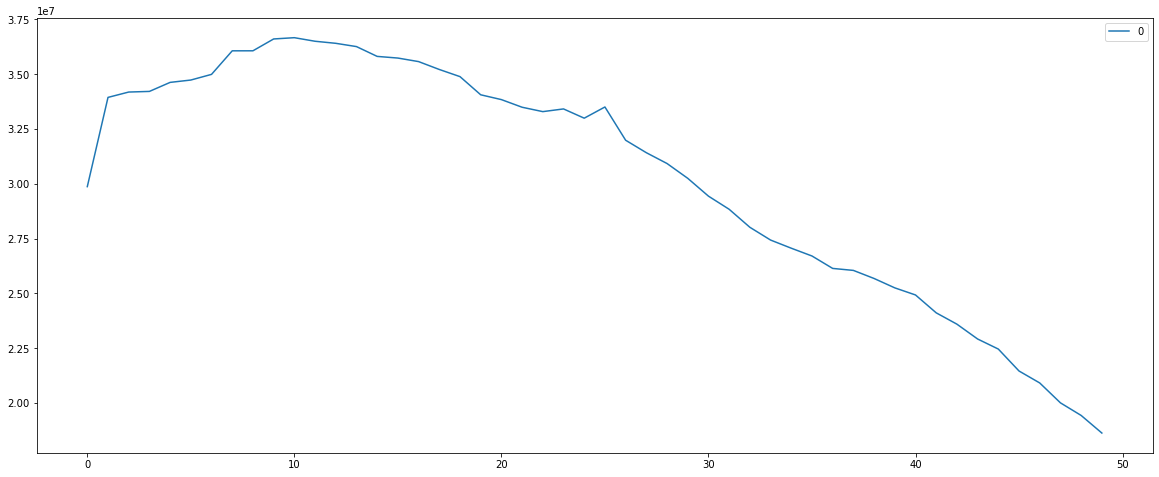

In [157]:
# Visualize total number of entries by collection (year and quarter)
total_count = pd.read_csv(r'./collection_total_count.csv')
total_count.plot(figsize=(20, 8))


## Gecoding

In [26]:
db['geodata'].find_one({'zip': '15537', 'city': 'Erkner'},  {'coordinates': 1}).get('coordinates')

[52.4272087, 13.7524646]

### Load data from phone book and geocode

Step 1/3: Query distinct zips and cities

In [139]:
start = time.time()
distinct_addresses = list(db['2018_Q3'].aggregate(
    [
        {'$group': {'_id': {'zip': '$zip', 'city': '$city'}}}
    ]))
elapsed_time(start, time.time())
# 57.6236629486084 seconds [2018_Q3]

'71.47518301010132 seconds'

Step 2/3: Parse cursor and convert to DataFrame

In [140]:
city_addresses = []
for a in distinct_addresses:
    zip = a['_id'].get('zip')
    city = a['_id'].get('city')
    city_addresses.append({'zip': zip, 'city': city})

In [141]:
city_addresses = pd.DataFrame(city_addresses)
city_addresses.sort_values(by='zip')

,zip,city
3380,.....,Schladen-Werla
24916,.....,Südliches Anhalt
21663,.....,Belgern-Schildau
20211,.....,Schindhard
3248,.....,Grabow-Below
...,...,...
36089,None,Zinzendorf
36099,None,Esslingen am Neckar
36222,None,Friedrichsdorf
36302,None,Wülfrath


Export results

In [183]:
city_addresses.sort_values(by='zip').to_csv(r'./2018_Q3_distinct_geodata.csv', index=False)

Step 3/3: Geocode results

In [193]:
start = time.time()
for address in city_addresses:
    
    # Example https://nominatim.openstreetmap.org/search.php?countrycode=de&q={12555%20Berlin}&format=jsonv2
    zip = address['zip']
    city = address['city']
    query_str = f'https://nominatim.openstreetmap.org/search.php?countrycode=de&q={zip}%20{city}&format=jsonv2'
    response = requests.get(query_str)
    response = response.json()

    if len(response) > 0:
        address['coordinates'] = f'{float(response[0].get('lat'))} {float(response[0].get('lon'))}'

elapsed_time(start, time.time())
# 18270.30997133255 seconds for 36352 records (≈ 5.07h)

'18270.30997133255 seconds'

Sort and insert into database collection

In [142]:
data = pd.DataFrame(city_addresses)
data.sort_values(by='zip', inplace=True)
create_collection('geodata', city_addresses, None)

'Collection geodata already exists.'

Create index on zips and cities

In [232]:
db.get_collection('geodata').create_index([('zip', 1), ('city', 1)])

'zip_1_city_1'

### Cleaning geo data

Geo data is being geocoded by using the OSM Nominatim API. Some coordinates are clearly not within the bounds of Germany and distort the overall picture.
A first attempt to clean the data is putting a rectangle on top, defining the most northern, southern, eastern and western points of Germany.
Another attempt can be by searching for specific coordinates of the outbreaks, in case they are known.

#### Attempt 1: Rectangle
##### Step 1/3: Load collection

In [219]:
geodata = pd.DataFrame(db['geodata'].find({}))
geodata.drop('index',1)

,_id,zip,city,coordinates,county,state
0,60130228360d927bdb0843ef,.....,Seeon-Seebruck,"[47.95816055, 12.470216551879616]",None,None
1,60130228360d927bdb0843f0,.....,Belgern-Schildau,"[51.46471555, 13.026622019540596]",None,None
2,60130228360d927bdb0843f1,.....,Vogtei,"[51.141569849999996, 10.40367219787925]",None,None
3,60130228360d927bdb0843f2,.....,Schloen-Dratow,"[53.5104874, 12.847652330627001]",None,None
4,60130228360d927bdb0843f3,.....,Hohe Börde,"[52.196924, 11.396162132482953]",None,None
...,...,...,...,...,...,...
36710,601ff7da096993a9fcf042ea,09434,Hohndorf,"[54.2993481, 9.5039415]",Erzgebirgskreis,Sachsen
36711,601ff7ea096993a9fcf042eb,36433,Immelborn,"[50.7938274, 10.2779644]",Wartburgkreis,Thüringen
36712,601ff7f5096993a9fcf042ec,98724,Neuhaus a. R.,"[50.496218915465185, 11.146780772784803]",Landkreis Sonneberg,Thüringen
36713,601ff7f5096993a9fcf042ed,.....,Frankenblick,"[50.3928032, 11.083933697790567]",None,None


In [149]:
geodata.to_csv(r'./archive/20210209_geodata.csv', index=False)

##### Step 2/3: Split coordinates into Lat and Lng

In [206]:
geodata = geodata.assign(lat=(geodata.coordinates.astype(str).str.strip('[]').str.split(',').str[0]).astype(float),
                 lng=geodata.coordinates.astype(str).str.strip('[]').str.split(',').str[1].astype(float)
                ).drop('coordinates',1)
geodata.sort_values(by=['lat'], ascending=True)

,_id,index,zip,city,county,state,lat,lng
26680,60130230360d927bdb08b5e0,26680,85235,Pfaffenhofen,None,None,47.277648,11.075017
26713,60130230360d927bdb08b601,26713,85261,Pfaffenhofen,None,None,47.277648,11.075017
32735,60130230360d927bdb08cfba,32735,NaN,Fürth,None,None,47.290785,12.744969
28787,60130230360d927bdb08bea1,28787,907..,Fürth Bay,None,None,47.290785,12.744969
28205,60130230360d927bdb08bc33,28205,8847.0,Schwendi,None,None,47.311589,9.058535
...,...,...,...,...,...,...,...,...
9346,60130228360d927bdb086bfb,9346,25999,Kampen,None,None,54.953770,8.344065
35594,601feae1096993a9fcf03e8e,35594,2285,Kampen Sylt,None,None,54.953770,8.344065
9339,60130228360d927bdb086bf4,9339,25992,Blidsel,None,None,55.001866,8.383158
9340,60130228360d927bdb086bf5,9340,25992,List,None,None,55.017740,8.435997


In [207]:
# multiple appearances of same coords
geodata.value_counts(['lat', 'lng'])

lat        lng      
52.501522  13.402550    104
50.938361  6.959974      95
48.137108  11.575382     93
50.110644  8.682092      73
51.225402  6.776314      73
                       ... 
50.458869  9.767940       1
48.133727  12.778867      1
50.458506  6.891779       1
50.458415  9.713309       1
50.657715  9.598409       1
Length: 27039, dtype: int64

##### Step 3/3: Find outbreaks
##### The most northern, southern, eastern and western points of Germany are:

    North: 55.0583° N, 8.4165° E  (> 55.06)
    South: 47.2701° N, 10.1783° E (< 47.25)
    East: 51.2729° N, 15.0419° E  (> 15.05)
    West: 51.0511° N, 5.8663° E   (< 5.85)
Coordinates exceeding the northernmost, southernmost, easternmost or westernmost point in the corresponding direction can be defined as "not lying within the borders of Germany".

In [208]:
north = geodata[geodata.lat > 55.06]
south = geodata[geodata.lat < 47.25]
east = geodata[geodata.lng > 15.05]
west = geodata[geodata.lng < 5.85]
print(f'N {len(north)}\nS {len(south)}\nE {len(east)}\nW {len(west)}')

N 0
S 0
E 0
W 0


In [35]:
north
# 82 records

,_id,zip,city,lat,lng
9,60130228360d927bdb0843f8,.....,Aland,60.216622,19.943864
1013,60130228360d927bdb084837,04317,None,60.982682,25.662733
3440,60130228360d927bdb0852c4,10001,Berlin,55.458909,10.038137
3441,60130228360d927bdb0852c5,10002,Berlin,55.458909,10.038137
3442,60130228360d927bdb0852c6,10042,Berlin,55.464008,10.048653
...,...,...,...,...,...
19510,6013022f360d927bdb089547,60311,None,59.369508,18.062986
20447,6013022f360d927bdb089939,6480.0,Dieburg,62.812851,6.880561
33154,60130230360d927bdb08cfad,None,Sande,63.017486,9.074074
33342,60130230360d927bdb08d06f,None,Petersberg,56.651946,-132.666544


In [494]:
north.value_counts(['lat', 'lng'])

lat        lng      
55.458909  10.038137    53
55.464008  10.048653    10
57.313171  25.274855     2
55.415221  10.465988     1
58.245382  8.143963      1
60.663596  6.535258      1
60.216622  19.943864     1
60.037652  17.666073     1
59.863525  10.785830     1
59.439768  24.755005     1
58.340457  15.619223     1
58.091338  6.806205      1
58.156662  7.099379      1
58.041495  11.858397     1
58.031473  13.231968     1
57.915932  12.370610     1
57.667198  15.837098     1
57.434145  14.881933     1
56.546832  16.146790     1
62.812851  6.880561      1
dtype: int64

In [36]:
south
# 108 records

,_id,zip,city,lat,lng
47,60130228360d927bdb08441e,.....,Melle,44.562048,7.320490
52,60130228360d927bdb084425,01013,Dresden,42.114437,-72.553610
59,60130228360d927bdb08442e,01099,None,27.896309,-82.733622
72,60130228360d927bdb08443c,01157,None,37.323959,127.015465
977,60130228360d927bdb08480a,04129,None,37.247512,127.067920
...,...,...,...,...,...
33504,60130230360d927bdb08d113,None,Oelsnitz,46.662464,16.165526
33578,60130230360d927bdb08d15e,None,Altdorf,46.875725,8.631635
33585,60130230360d927bdb08d165,None,Lastrup,46.039409,-94.063322
33611,60130230360d927bdb08d17f,None,81369,27.896309,-82.733622


In [496]:
south.value_counts(['lat', 'lng'])

lat         lng        
-33.045627  -71.582135     26
 46.845804   7.234153       4
 47.160492   10.313097      2
-33.038275  -71.348203      2
 42.914760   12.850283      2
                           ..
 39.238797  -79.414475      1
 38.604363  -90.996301      1
 38.344729  -75.183674      1
 37.377215  -109.741951     1
 43.179857  -83.897333      1
Length: 77, dtype: int64

In [597]:
east
# 44 records

,_id,zip,city,lat,lng
33830,6015ac02ca3c4e0b973fb3a0,99735,Petersdorf,59.9449,30.365039


In [498]:
east.value_counts(['lat', 'lng'])

lat         lng       
 48.579743  15.581660     2
 57.313171  25.274855     2
-37.540278  176.429167    1
 53.121026  15.702396     1
 48.730540  17.856046     1
 50.012378  20.988074     1
 50.430876  15.469506     1
 50.900906  17.476581     1
 51.137373  20.590225     1
 51.176667  16.167222     1
 51.211389  15.969167     1
 53.744565  16.354940     1
-27.974445  152.682220    1
 54.095352  15.320558     1
 54.559801  16.912959     1
 56.546832  16.146790     1
 57.667198  15.837098     1
 58.340457  15.619223     1
 59.439768  24.755005     1
 60.037652  17.666073     1
 48.298748  15.186451     1
 48.259918  16.367112     1
 48.249551  15.704791     1
 48.208354  16.372504     1
-22.573245  17.092484     1
 7.055894   125.566034    1
 8.118858   16.915619     1
 14.889256  120.237893    1
 14.899024  120.243954    1
 16.830721  96.257885     1
 18.209639  83.488609     1
 45.043705  16.373721     1
 47.465938  18.972620     1
 47.594503  16.116950     1
 47.680306  16.598346    

In [51]:
west
# 34 records

,_id,zip,city,lat,lng
36666,601ff09f096993a9fcf042be,55758,Sien,50.856097,4.449431


In [567]:
west.value_counts(['lat', 'lng'])

lat        lng        
51.462680   4.451170      16
50.860360   5.785870       5
53.743572  -0.339476       2
49.402552   0.799198       2
51.255302   3.292091       1
52.188156  -2.220067       1
51.978838   5.797832       1
51.555595  -0.286087       1
51.522996  -0.143945       1
51.500365  -0.052602       1
51.493158  -0.370304       1
51.416297   3.702806       1
48.387694  -4.480093       1
48.896502   2.401980       1
50.745030   4.346369       1
50.645138   5.573420       1
50.518086   5.240814       1
49.822004  -97.128965      1
49.740000   3.771389       1
49.207384  -123.140394     1
48.991438   2.665239       1
51.110569   4.914978       1
dtype: int64

Export (appending)

In [204]:
# TEST
updates = []
for _, d in update_df.iterrows():
  updates.append(UpdateOne({'_id': d.get('_id')}, {'$set': {'coordinates': d.get('coordinates')}}, upsert=True))

db['geodata'].bulk_write(updates)
print('Done.')

Done.


In [617]:
north.to_csv('./stats/outbreaks_north.csv', mode='a', header=False, index=False)
north.value_counts(['lat', 'lng']).to_csv('./stats/outbreaks_north_counts.csv', mode='a', header=False, index=False)
south.to_csv('./stats/outbreaks_south.csv', mode='a', header=False, index=False)
south.value_counts(['lat', 'lng']).to_csv('./stats/outbreaks_south_counts.csv', mode='a', header=False, index=False)
east.to_csv('./stats/outbreaks_east.csv', mode='a', header=False, index=False)
east.value_counts(['lat', 'lng']).to_csv('./stats/outbreaks_east_counts.csv', mode='a', header=False, index=False)
west.to_csv('./stats/outbreaks_west.csv', mode='a', header=False, index=False)
west.value_counts(['lat', 'lng']).to_csv('./stats/outbreaks_west_counts.csv', mode='a', header=False, index=False)
print('Successfully exported')

Successfully exported


##### Delete data from collection
##### Step 1/2: Get document ids of outbreaking records

In [37]:
ids = []
data_series = [north['_id'], south['_id'], east['_id'], west['_id']]
for ds in data_series:
    for i in ds:
        ids.append(i)
ids

[ObjectId('60130228360d927bdb0843f8'),
 ObjectId('60130228360d927bdb084837'),
 ObjectId('60130228360d927bdb0852c4'),
 ObjectId('60130228360d927bdb0852c5'),
 ObjectId('60130228360d927bdb0852c6'),
 ObjectId('60130228360d927bdb0852c7'),
 ObjectId('60130228360d927bdb0852c8'),
 ObjectId('60130228360d927bdb0852c9'),
 ObjectId('60130228360d927bdb0852ca'),
 ObjectId('60130228360d927bdb0852cb'),
 ObjectId('60130228360d927bdb0852d1'),
 ObjectId('60130228360d927bdb0852d4'),
 ObjectId('60130228360d927bdb0852d5'),
 ObjectId('60130228360d927bdb0852e6'),
 ObjectId('60130228360d927bdb0852e7'),
 ObjectId('60130228360d927bdb0852e8'),
 ObjectId('60130228360d927bdb0852ea'),
 ObjectId('60130228360d927bdb0852ed'),
 ObjectId('60130228360d927bdb0852ee'),
 ObjectId('60130228360d927bdb0852f8'),
 ObjectId('60130228360d927bdb0852f9'),
 ObjectId('60130228360d927bdb0852fa'),
 ObjectId('60130228360d927bdb085301'),
 ObjectId('60130228360d927bdb085302'),
 ObjectId('60130228360d927bdb085303'),
 ObjectId('60130228360d92

##### Step 2/2: Remove documents from collection

In [38]:
db['geodata'].delete_many({'_id': {'$in': ids }})
print('Documents successfully removed')

Documents successfully removed


#### Attempt 2: Specific coordinates
The first attempt is not very accurate, because the borders of Germany do not exactly fill a rectangle.
The second attempt allows to query coordinates to specific outbreaks. It may also include a tolerance if the coordinates vary by a few decimals

In [163]:
specific_geodata = pd.DataFrame(db['geodata'].find({
    "coordinates": {
        "$geoWithin": {
            "$centerSphere": [[
               48.1690157,
               14.5292278
            ], 0.005000 ]
        }
    }
}))
geodata

,_id,zip,city,coordinates,county,state
0,6012fc0e360d927bdb082685,84375,Kirchdorf,"[48.1690157, 14.5292278]",Landkreis Rottal-Inn,Bayern
1,6012fc0e360d927bdb082891,85414,Kirchdorf,"[48.1690157, 14.5292278]",Landkreis Freising,Bayern
2,6012fc0e360d927bdb083637,94261,Kirchdorf,"[48.1690157, 14.5292278]",Landkreis Regen,Bayern


In [ ]:
db['geodata'].delete_many({'_id': {'$in': specific_geodata }})
print('Documents successfully removed')

### Assign state and county

##### Step 1/4:
Load zip-county-state information from CSV file or database

##### CSV:

In [209]:
zip_df = pd.read_csv(r'../archive/csv/zuordnung_plz_ort_landkreis.csv')
zip_df.sort_values(by='plz').value_counts('plz')

plz
54636    39
56357    33
7646     33
55758    33
54597    31
         ..
52372     1
52355     1
52353     1
52351     1
1067      1
Length: 8168, dtype: int64

Rename columns

In [210]:
zip_df.rename(columns={'ort': 'city', 'plz': 'zip', 'landkreis': 'county', 'bundesland': 'state'}, inplace=True)
zip_df

,osm_id,ags,city,zip,county,state
0,1104550,8335001,Aach,78267,Landkreis Konstanz,Baden-Württemberg
1,1255910,7235001,Aach,54298,Landkreis Trier-Saarburg,Rheinland-Pfalz
2,62564,5334002,Aachen,52062,Städteregion Aachen,Nordrhein-Westfalen
3,62564,5334002,Aachen,52064,Städteregion Aachen,Nordrhein-Westfalen
4,62564,5334002,Aachen,52066,Städteregion Aachen,Nordrhein-Westfalen
...,...,...,...,...,...,...
12878,2778122,8415085,Zwiefalten,88529,Landkreis Reutlingen,Baden-Württemberg
12879,959161,9276148,Zwiesel,94227,Landkreis Regen,Bayern
12880,403750,8225113,Zwingenberg,69439,Neckar-Odenwald-Kreis,Baden-Württemberg
12881,537054,6431022,Zwingenberg,64673,Kreis Bergstraße,Hessen


In [211]:
create_collection('zips_cities_counties_states', zip_df, None)

'Collection zips_cities_counties_states successfully inserted. 0.6872262954711914 seconds'

##### Database:

In [14]:
zip_df = pd.DataFrame(db.zips_cities_counties_states.find({}))
zip_df.value_counts('zip')

zip
54636    39
56357    33
7646     33
55758    33
54597    31
         ..
52372     1
52355     1
52353     1
52351     1
1067      1
Length: 8168, dtype: int64

##### Step 2/4:
Load currently existing data from the database.

In [212]:
geodata_df = pd.DataFrame(db['geodata'].find({}))
geodata_df

,_id,index,zip,city,coordinates,county,state
0,60130228360d927bdb0843ef,0,.....,Seeon-Seebruck,"[47.95816055, 12.470216551879616]",None,None
1,60130228360d927bdb0843f0,1,.....,Belgern-Schildau,"[51.46471555, 13.026622019540596]",None,None
2,60130228360d927bdb0843f1,2,.....,Vogtei,"[51.141569849999996, 10.40367219787925]",None,None
3,60130228360d927bdb0843f2,3,.....,Schloen-Dratow,"[53.5104874, 12.847652330627001]",None,None
4,60130228360d927bdb0843f3,4,.....,Hohe Börde,"[52.196924, 11.396162132482953]",None,None
...,...,...,...,...,...,...,...
36709,601ff7d8096993a9fcf042e9,36709,23996,Gallentin,"[53.7578829, 11.4488488]",None,None
36710,601ff7da096993a9fcf042ea,36710,09434,Hohndorf,"[54.2993481, 9.5039415]",None,None
36711,601ff7ea096993a9fcf042eb,36711,36433,Immelborn,"[50.7938274, 10.2779644]",None,None
36712,601ff7f5096993a9fcf042ec,36712,98724,Neuhaus a. R.,"[50.496218915465185, 11.146780772784803]",None,None


##### Query for specific information in the DataFrames
i.e. Find all documents by zip

In [643]:
zip_df.loc[zip_df['zip'] == 55758]

,osm_id,ags,city,zip,county,state
152,1245131,7134003,Allenbach,55758,Landkreis Birkenfeld,Rheinland-Pfalz
387,1245096,7134004,Asbach,55758,Landkreis Birkenfeld,Rheinland-Pfalz
718,1244080,7133008,Bärenbach,55758,Landkreis Bad Kreuznach,Rheinland-Pfalz
1682,1245128,7134013,Breitenthal,55758,Landkreis Birkenfeld,Rheinland-Pfalz
1802,1245143,7134014,Bruchweiler,55758,Landkreis Birkenfeld,Rheinland-Pfalz
2310,1245073,7134019,Dickesbach,55758,Landkreis Birkenfeld,Rheinland-Pfalz
4944,1245106,7134037,Hellertshausen,55758,Landkreis Birkenfeld,Rheinland-Pfalz
4994,1245136,7134038,Herborn,55758,Landkreis Birkenfeld,Rheinland-Pfalz
5090,1245134,7134040,Hettenrodt,55758,Landkreis Birkenfeld,Rheinland-Pfalz
5437,1245101,7134044,Hottenbach,55758,Landkreis Birkenfeld,Rheinland-Pfalz


In [29]:
geodata_df.loc[geodata_df['zip'] == '55758'].sort_values(by='city')

,_id,zip,city,coordinates
17686,6012fc0e360d927bdb080088,55758,Allenbach,"[49.7637907, 7.149876762489359]"
17684,6012fc0e360d927bdb080085,55758,Asbach,"[49.812553, 7.2785927]"
17681,6012fc0e360d927bdb08007e,55758,Breitenthal,"[49.8004413, 7.3350745]"
17687,6012fc0e360d927bdb080089,55758,Bruchweiler,"[49.7996455, 7.226148940473375]"
17680,6012fc0e360d927bdb08007d,55758,Bärenbach,"[49.7472894, 7.4413713]"
17670,6012fc0e360d927bdb080072,55758,Dickesbach,"[49.7185284, 7.4235905]"
17672,6012fc0e360d927bdb080074,55758,Hammerbirkenfeld,"[49.8115468, 7.2404643]"
17675,6012fc0e360d927bdb080077,55758,Hellertshausen,"[49.8208941, 7.2744376]"
17668,6012fc0e360d927bdb080070,55758,Herborn,"[49.7674455, 7.2952179]"
17678,6012fc0e360d927bdb08007a,55758,Hettenrodt,"[49.7407782, 7.2531203]"


In [135]:
counties_df = pd.DataFrame(list(zip_df.county.unique()), columns=['county'])
counties_df

,county
0,Landkreis Konstanz
1,Landkreis Trier-Saarburg
2,Städteregion Aachen
3,Ostalbkreis
4,Rheingau-Taunus-Kreis
...,...
290,Landkreis Sonneberg
291,Landkreis St. Wendel
292,Regionalverband Saarbrücken
293,Landkreis Kulmbach


In [117]:
states_df = pd.DataFrame(list(zip_df.state.unique()), columns=['state'])
states_df

,state
0,Baden-Württemberg
1,Rheinland-Pfalz
2,Nordrhein-Westfalen
3,Hessen
4,Schleswig-Holstein
5,Bayern
6,Thüringen
7,Niedersachsen
8,Mecklenburg-Vorpommern
9,Sachsen


##### Step 3/4:
Assign county and state according to zip

In [213]:
start = time.time()
new_df = None
for z in zip_df.zip.unique():
    cs_df = zip_df.loc[zip_df['zip'] == z]
    county = cs_df.county.iloc[0]
    state = cs_df.state.iloc[0]
    if z < 10000:
        z = '0' + str(z)
    else: z = str(z)
    gd_df = geodata_df.loc[geodata_df['zip'] == z].copy(deep=True)
    gd_df['county'] = county
    gd_df['state'] = state
    if new_df is None:
        new_df = gd_df.copy(deep=True)
        continue
    nd = new_df.copy(deep=True)
    new_df = nd.append(gd_df)
    
elapsed_time(start, time.time())
# '74.98189115524292 seconds' for 29879/
# '94.82572221755981 seconds' for 36714

'94.82572221755981 seconds'

In [214]:
# view results
new_df

,_id,index,zip,city,coordinates,county,state
23992,60130230360d927bdb08aa73,23992,78267,Aach,"[47.8441308, 8.8519587]",Landkreis Konstanz,Baden-Württemberg
23993,60130230360d927bdb08aa74,23993,78267,Aach Hegau,"[47.8399386, 8.8523338]",Landkreis Konstanz,Baden-Württemberg
16560,6013022f360d927bdb08897d,16560,54298,Igel,"[49.7089913, 6.5539804]",Landkreis Trier-Saarburg,Rheinland-Pfalz
16561,6013022f360d927bdb08897e,16561,54298,Orenhofen,"[49.8998203, 6.66082213928834]",Landkreis Trier-Saarburg,Rheinland-Pfalz
16562,6013022f360d927bdb08897f,16562,54298,Eisenach,"[49.85134445, 6.512078825687435]",Landkreis Trier-Saarburg,Rheinland-Pfalz
...,...,...,...,...,...,...,...
21702,60130230360d927bdb08a042,21702,69439,Zwingenberg Baden,"[49.4157852, 9.0430119]",Neckar-Odenwald-Kreis,Baden-Württemberg
21703,60130230360d927bdb08a043,21703,69439,Zwingenberg,"[49.4191717, 9.0405229]",Neckar-Odenwald-Kreis,Baden-Württemberg
20016,6013022f360d927bdb0898c7,20016,64673,Zwingenberg,"[49.7247617, 8.612855]",Kreis Bergstraße,Hessen
2875,60130228360d927bdb08506f,2875,08297,Zwönitz,"[50.6301029, 12.8131994]",Erzgebirgskreis,Sachsen


##### Step 4/4:
Update geodata database

In [215]:
updates = []
for _, d in new_df.iterrows():
  updates.append(UpdateOne({'_id': d.get('_id')}, {'$set': {'county': d.get('county'), 'state': d.get('state')}}, upsert=True))

db['geodata'].bulk_write(updates)
print('Done.')

Done.


## Vizualization / Graphs

Simple 3-step setup to plot a graph

### Single plot setup

##### Step 1: Load data

In [231]:
total_count = pd.read_csv(r'./stats/collection_total_count.csv')

In [186]:
# available styles
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


##### Step 2: Assign axes data, format and plot figure

In [232]:
x_axis = total_count.year
y_values = total_count.total_entries
# avoiding scientific notation 1e7
y_axis = []
for y in y_values:
    y_axis.append(y/1000000)
y_axis

[29.874373,
 33.945932,
 34.189903,
 34.218752,
 34.630715,
 34.737798,
 34.996369,
 36.070875,
 36.071839,
 36.61203,
 36.67012,
 36.507298,
 36.413412,
 36.26392,
 35.816449,
 35.740602,
 35.579271,
 35.21978,
 34.893504,
 34.064787,
 33.845067,
 33.496665,
 33.296488,
 33.419698,
 32.997594,
 33.508623,
 31.991441,
 31.422485,
 30.928821,
 30.253832,
 29.440657,
 28.840824,
 28.019802,
 27.437004,
 27.064763,
 26.709613,
 26.142689,
 26.05221,
 25.683384,
 25.2555,
 24.931627,
 24.116086,
 23.599598,
 22.922351,
 22.463256,
 21.462263,
 20.916704,
 20.009223,
 19.434843,
 18.632177]

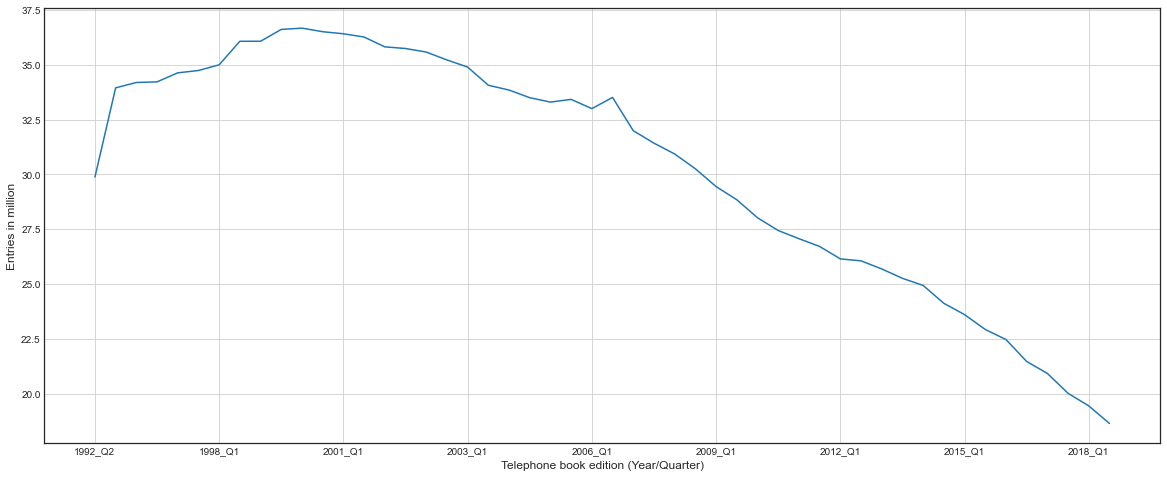

In [233]:
# Visualize total number of entries by collection (year and quarter)
plt.style.use('seaborn-white')
# plt.title('Total number of entries per telephone book edition (1992 - 2018)', fontdict={'size':14})
plt.figure(figsize=(20,8))
plt.plot(x_axis, y_axis)
plt.xlabel('Telephone book edition (Year/Quarter)', fontdict={'size':12})
plt.ylabel('Entries in million', fontdict={'size':12})
plt.grid(True)
plt.xticks(x_axis[0::6])
plt.savefig('./figures/fig_total_number_entries.png')
plt.show()

### Multiple plots in one graph

##### Step 1/4: Load data

In [224]:
graph_data_df = pd.read_csv(r'./stats/abbreviated_names.csv')
graph_data_df

,collection,fn_one,fn_one_dot,fn_none,fn_ln_none,ln_none,ln_one,ln_one_dot,total
0,1992_Q2,227,1943563,3147863.0,894419.0,894910.0,308.0,338.0,29874373.0
1,1995_Q0,108,2225041,4095130.0,1470004.0,1470593.0,354.0,154.0,33945932.0
2,1996_Q0,109,2229484,4135597.0,1499613.0,1500192.0,352.0,154.0,34189903.0
3,1996_Q1,106,2224907,4143945.0,1507692.0,1508263.0,342.0,116.0,34218752.0
4,1997_Q1,82,2165442,4286191.0,1618826.0,1619403.0,324.0,97.0,34630715.0
5,1997_Q3,85,2130247,4485546.0,1666754.0,1667377.0,297.0,102.0,34737798.0
6,1998_Q1,96,2108729,4704795.0,1884246.0,1884950.0,288.0,108.0,34996369.0
7,1998_Q3,114,2091444,5326020.0,2079914.0,2080745.0,275.0,101.0,36070875.0
8,1999_Q1,122,2046452,5149321.0,1843717.0,1844472.0,261.0,99.0,36071839.0
9,1999_Q3,193,1985407,5382932.0,2064938.0,2065590.0,204.0,96.0,36612030.0


##### Step 2/4: Assign x-axis (reference axis for all plots)

In [225]:
x_axis = total_count.year

##### Step 3/4: Assign multiple y-axes

In [226]:
# avoiding scientific notation (e.g. 1e7)
def adjust_axis_values(values, divider):
    y_axis = []
    for y in values:
        y_axis.append(y/divider)
    return y_axis

In [227]:
y_total = adjust_axis_values(graph_data_df.total, 1000000)
y_fn_none = adjust_axis_values(graph_data_df.fn_none, 1000000)
y_fn_one = adjust_axis_values(graph_data_df.fn_one, 1000000)
y_fn_one_dot = adjust_axis_values(graph_data_df.fn_one_dot, 1000000)
y_fn_ln_none = adjust_axis_values(graph_data_df.fn_ln_none, 1000000)
y_ln_none = adjust_axis_values(graph_data_df.ln_none, 1000000)
y_ln_one = adjust_axis_values(graph_data_df.ln_one, 1000000)
y_ln_one_dot = adjust_axis_values(graph_data_df.ln_one_dot, 1000000)

##### Step 4/4: Setup plot

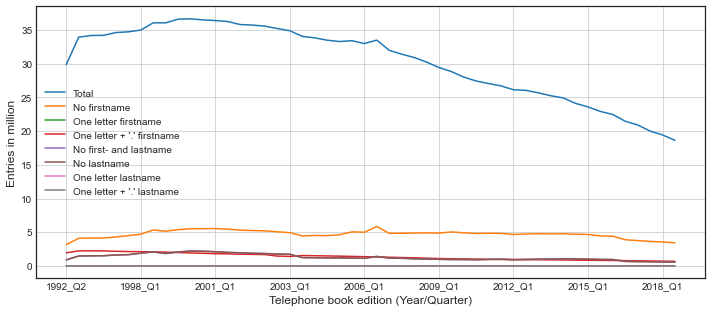

In [228]:
plt.style.use('seaborn-white')
plt.figure(figsize=(12,5))

plt.plot(x_axis, y_total, label='Total')
plt.plot(x_axis, y_fn_none, label='No firstname')
plt.plot(x_axis, y_fn_one, label='One letter firstname')
plt.plot(x_axis, y_fn_one_dot, label='One letter + \'.\' firstname')
plt.plot(x_axis, y_fn_ln_none, label='No first- and lastname')
plt.plot(x_axis, y_ln_none, label='No lastname')
plt.plot(x_axis, y_ln_one, label='One letter lastname')
plt.plot(x_axis, y_ln_one_dot, label='One letter + \'.\' lastname')
plt.xlabel('Telephone book edition (Year/Quarter)', fontdict={'size':12})
plt.ylabel('Entries in million', fontdict={'size':12})
plt.legend()
plt.grid(True)
plt.xticks(x_axis[0::6])
plt.savefig('./figures/fig_abbreviated_names.png')
plt.show()

## Backup
Dumping, Restoring collections

Assign values to y-axis